# Simulation of Hi-C data

In [1]:
import sys
sys.path.insert(1, '/home/elinfi/MasterCode/clustering/class/')

In [2]:
import cooltools.lib.plotting

import numpy as np
import matplotlib as mpl
import pretty_plotting as pplot
import matplotlib.pyplot as plt
import change_functions as cf

from simulate_data import SimulateData
from mid_point_log_norm import MidPointLogNorm
from matplotlib.ticker import LogLocator, LogFormatterSciNotation

In [3]:
# globally set font sizes
pplot.font_size(12, 14, 16)

## Initialization
Specify the **resolution** and **maximum range** of simulated matrix.

In [4]:
resolution = 32000
max_range = 5e6
ntads = 2

In [5]:
simulation = SimulateData(resolution, max_range, ntads)

## Change TAD
Change interaction frequency of TAD according to own defined function.

In [6]:
simulation.change_tad(cf.constant, n=1, random_state=None, k=1)

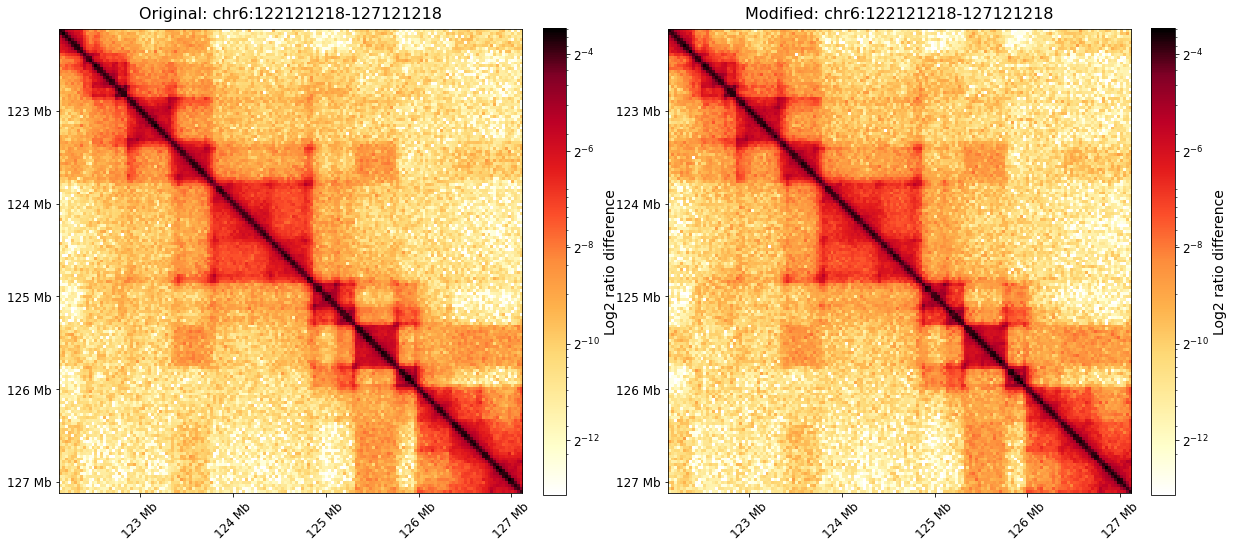

In [7]:
f, axs = plt.subplots(figsize=(20, 20),
                      nrows=1,
                      ncols=2,
                      sharex=True, sharey=False)

norm = mpl.colors.LogNorm()
extent=pplot.region2extent(simulation.mat_region)

ax = axs[0]
im = ax.matshow(simulation.mat1,
                cmap='fall',
                norm=norm,
                extent=extent)
plt.colorbar(im, fraction=0.046, pad=0.04, label='Log2 ratio difference', ax=ax,
             ticks=LogLocator(base=2), format=LogFormatterSciNotation(base=2))
ax.set_title('Original: ' + simulation.mat_region, y=1.01)
#plt.savefig('../Figures/sub_002_001.png')
pplot.format_ticks(ax)

ax = axs[1]
im = ax.matshow(simulation.mat2,
                cmap='fall',
                norm=norm,
               extent=extent)
plt.colorbar(im, fraction=0.046, pad=0.04, label='Log2 ratio difference', ax=ax,
             ticks=LogLocator(base=2), format=LogFormatterSciNotation(base=2))
ax.set_title('Modified: ' + simulation.mat_region, y=1.01)
pplot.format_ticks(ax)
plt.savefig('../../Figures/Simulation/org_mod.png')

## Change TAD-TAD 

In [8]:
simulation.change_tad_tad(cf.constant, random_state=None, k=2)

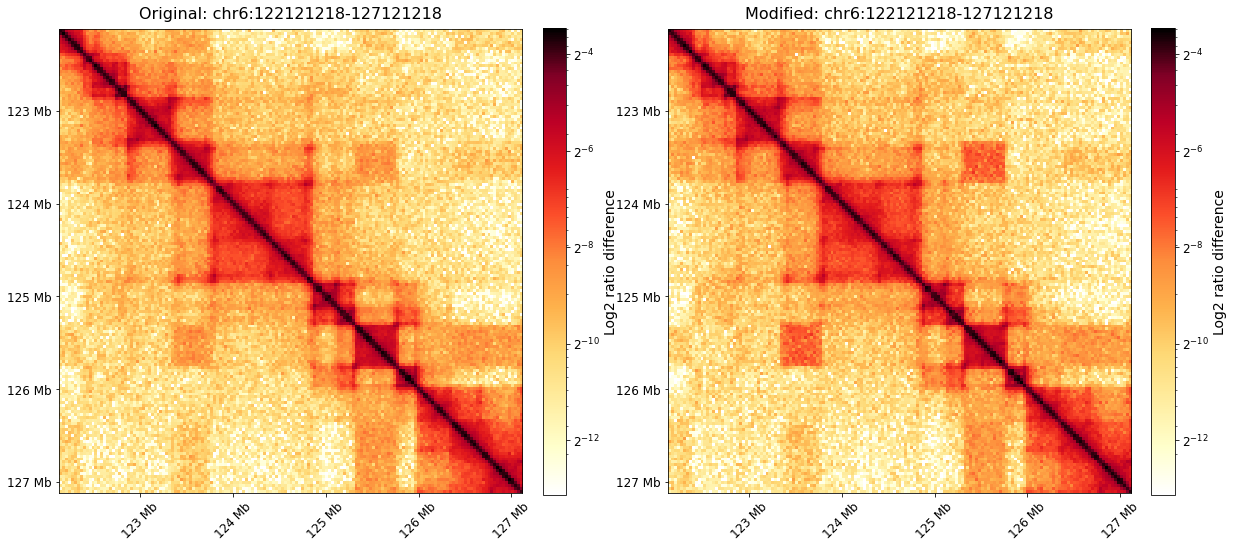

In [9]:
f, axs = plt.subplots(figsize=(20, 20),
                      nrows=1,
                      ncols=2,
                      sharex=True, sharey=False)

norm = mpl.colors.LogNorm()
extent=pplot.region2extent(simulation.mat_region)

ax = axs[0]
im = ax.matshow(simulation.mat1,
                cmap='fall',
                norm=norm,
                extent=extent)
plt.colorbar(im, fraction=0.046, pad=0.04, label='Log2 ratio difference', ax=ax,
             ticks=LogLocator(base=2), format=LogFormatterSciNotation(base=2))
ax.set_title('Original: ' + simulation.mat_region, y=1.01)
pplot.format_ticks(ax)

ax = axs[1]
im = ax.matshow(simulation.mat2,
                cmap='fall',
                norm=norm,
               extent=extent)
plt.colorbar(im, fraction=0.046, pad=0.04, label='Log2 ratio difference', ax=ax,
             ticks=LogLocator(base=2), format=LogFormatterSciNotation(base=2))
ax.set_title('Modified: ' + simulation.mat_region, y=1.01)
pplot.format_ticks(ax)
plt.savefig('../../Figures/Simulation/org_mod.png')

## Change loops

In [10]:
simulation.change_loop(cf.constant, n=7, random_state=None, k=10)

7
7


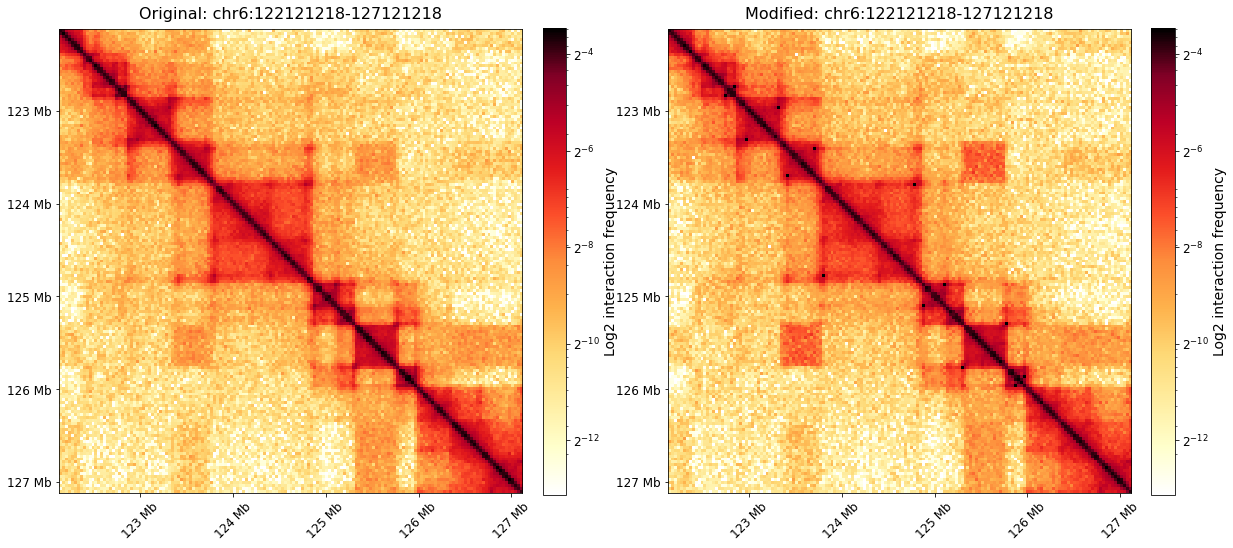

In [18]:
f, axs = plt.subplots(figsize=(20, 20),
                      nrows=1,
                      ncols=2,
                      sharex=True, sharey=False)

norm = mpl.colors.LogNorm()
extent=pplot.region2extent(simulation.mat_region)

ax = axs[0]
im = ax.matshow(simulation.mat1,
                cmap='fall',
                norm=norm,
                extent=extent)
plt.colorbar(im, fraction=0.046, pad=0.04, label='Log2 interaction frequency', ax=ax,
             ticks=LogLocator(base=2), format=LogFormatterSciNotation(base=2))
ax.set_title('Original: ' + simulation.mat_region, y=1.01)
pplot.format_ticks(ax)

ax = axs[1]
im = ax.matshow(simulation.mat2,
                cmap='fall',
                norm=norm,
               extent=extent)
plt.colorbar(im, fraction=0.046, pad=0.04, label='Log2 interaction frequency', ax=ax,
             ticks=LogLocator(base=2), format=LogFormatterSciNotation(base=2))
ax.set_title('Modified: ' + simulation.mat_region, y=1.01)
pplot.format_ticks(ax)
plt.savefig('../../Figures/Simulation/org_mod.png')

## Compare simulation matrices

### Ratio

In [12]:
method = 'ratio'
diff_ratio = simulation.compare(method=method)

/home/elinfi/MasterCode/clustering/class/mid_point_log_norm.py:12: RuntimeWarning: divide by zero encountered in log
  return np.ma.array(np.interp(np.log(value), x, y), mask=result.mask, copy=False)


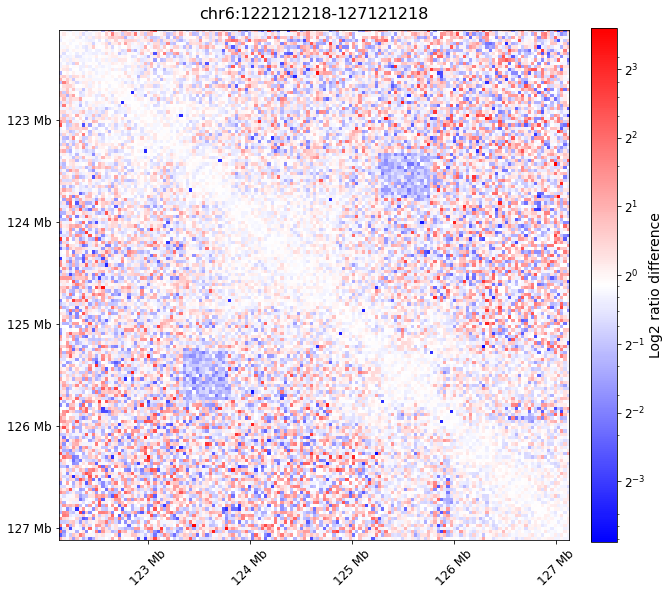

In [13]:
f, axs = plt.subplots(figsize=(10, 10),
                      nrows=1,
                      ncols=1,
                      sharex=True, sharey=False)

norm = MidPointLogNorm(midpoint=1)
extent=pplot.region2extent(simulation.mat_region)

ax = axs
im = ax.matshow(diff_ratio,
                cmap='bwr',
                norm=norm,
               extent=extent)
plt.colorbar(im, fraction=0.046, pad=0.04, label='Log2 ratio difference', ax=ax,
             ticks=LogLocator(base=2), format=LogFormatterSciNotation(base=2))
ax.set_title(simulation.mat_region, y=1.01)
pplot.format_ticks(ax)
plt.savefig('../../Figures/Simulation/sim_ratio.png')

### Relative difference

In [14]:
method = 'reldiff'
diff_rel = simulation.compare(method=method)

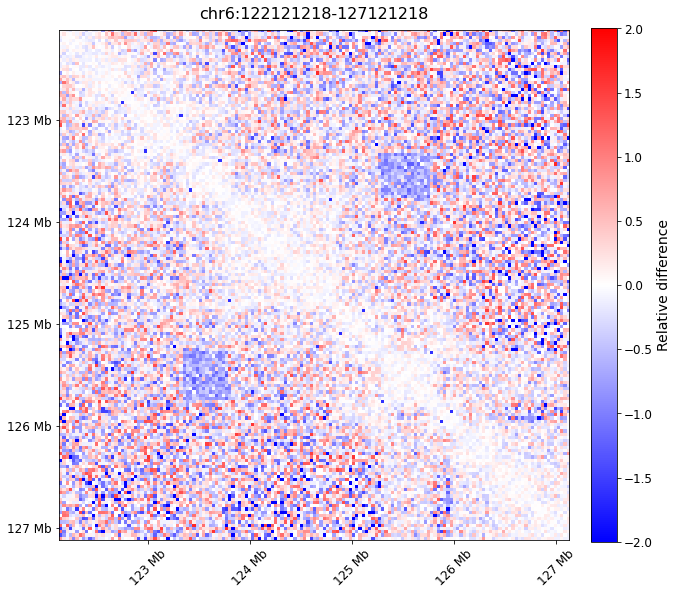

In [15]:
f, axs = plt.subplots(figsize=(10, 10),
                      nrows=1,
                      ncols=1,
                      sharex=True, sharey=False)
ax = axs
vmax = np.nanmax(abs(diff_rel))
extent=pplot.region2extent(simulation.mat_region)

im = ax.matshow(diff_rel,
                vmax=vmax,
                vmin=-vmax,
                cmap='bwr',
                extent=extent)
plt.colorbar(im, fraction=0.046, pad=0.04, label='Relative difference', ax=ax)
ax.set_title(simulation.mat_region, y=1.01)
pplot.format_ticks(ax)
plt.savefig('../../Figures/Simulation/sim_reldiff.png')

In [16]:
filename = '../../Simulations/reldiff.npy'
simulation.write2file(filename, diff_rel)